# 전이 학습(transfer learning)

<img src = "./image/transfer_learning.png">

- 일반적으로 합성곱 신경망 기반의 딥러닝 모델을 제대로 훈련시키려면 많은 양의 데이터가 필요함
- 큰 데이터셋을 확보하고 훈련시키려면 많은 돈과 시간이 필요하기 때문에 쉽지 않음

- 전이 학습
    - 아주 큰 데이터셋을 써서 잘 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것을 의미
    - 이 때, 아주 큰 데이서셋을 잘 학습한 모델을 사전 학습 모델(사전 훈련된 모델)
    - 전이 학습을 이용하면 비교적 적은 수의 데이터를 가지고도 원하는 과제를 수행할 수 있음
    
- 전이 학습 기법
    - 특성 추출(feature extractor)
    - 미세 조정(fine tuning)

## 특성 추출 기법

<img src = "./image/feature_extractor.jpg">

- 사전 학습 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만듦
- 학습할 때는 완전연결층만 학습하고 나머지 계층들은 학습되지 않도록 함
    - 합성곱층 : 합성곱층과 풀링층으로 구성되어 이미지를 해석하는 부분
    - 데이터 분류기(완전연결층) : 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분

- 이미지 분류 사전학습 모델
    - Xception
    - Inception V3
    - ResNet50
    - VGG16
    - VGG19
    - MobileNet

In [1]:
import os
import time
import copy
import glob
import cv2
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [7]:
data_path = "./data/catanddog/train"

transform = transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    num_workers = 8,
    shuffle = True)

print(len(train_dataset))

385


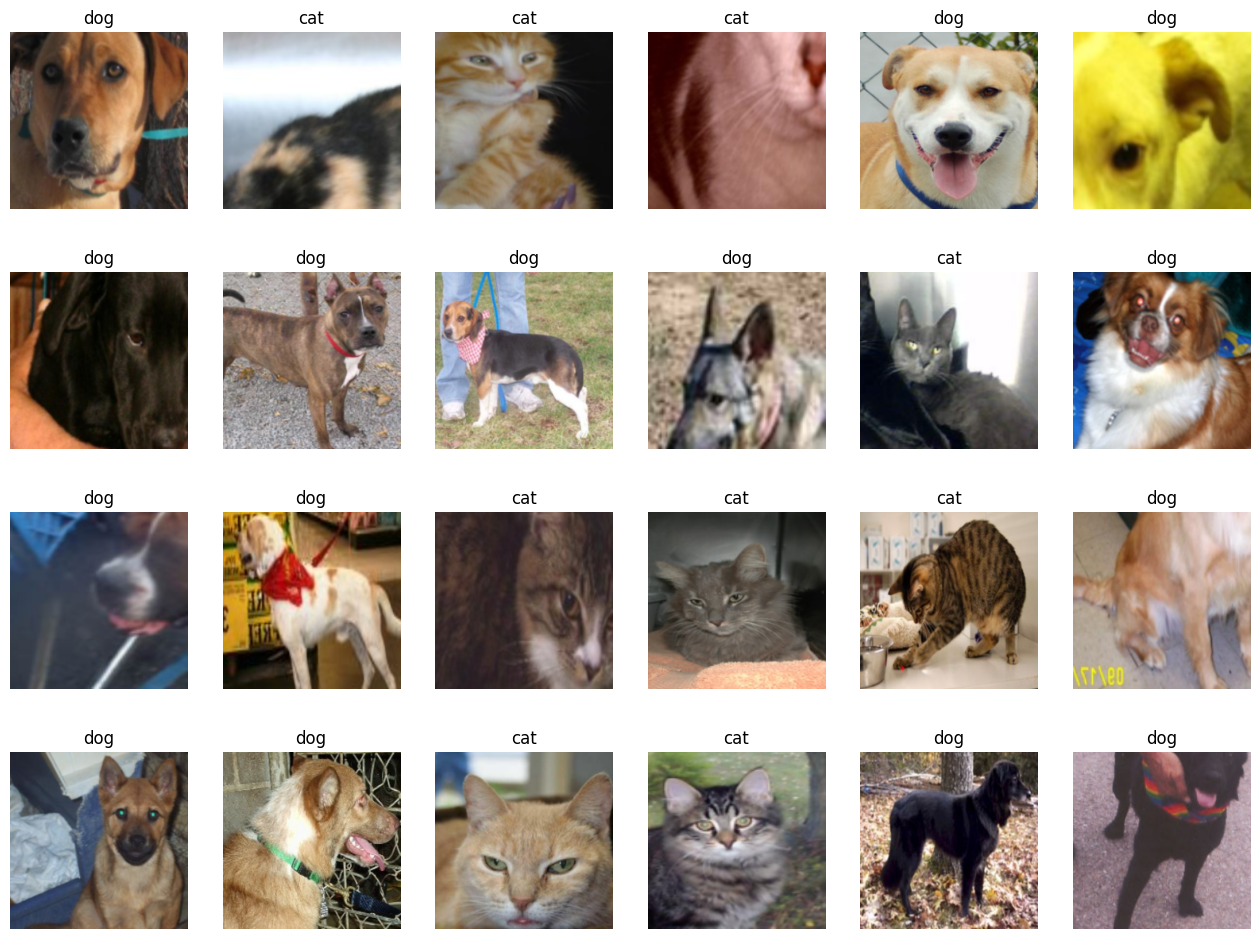

In [8]:
# 학습에 사용될 이미지 출력
samples, labels = next(iter(train_loader)) # train_loader에서 데이터를 하나씩 꺼내 오기
classes = {0 : "cat", 1 : "dog"}
fig = plt.figure(figsize = (16, 24))

for i in range(24):
    a = fig.add_subplot(4, 6, i + 1)
    a.set_title(classes[labels[i].item()])
    a.axis("off")
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0))) # 파이토치에서는 채널이 제일 앞으로 옴 (3, 224, 224). 
                                                          # 따라서 순서를 np.transpose로 224, 224 3으로 변환

plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

In [9]:
samples.shape

torch.Size([32, 3, 224, 224])

In [10]:
np.transpose(samples[0].numpy(), (1, 2, 0)).shape

(224, 224, 3)

# 사전학습 모델 준비

In [11]:
resnet18 = models.resnet18(pretrained = True)  # pretrained = True : 사전 학습된 가중치를 사용하겠다

C:\Users\JONGYEOB\Anaconda3\envs\final_project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\JONGYEOB\Anaconda3\envs\final_project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\JONGYEOB/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## ResNet18

- 50개의 계층으로 구성된 합성곱 신경망
- ImageNet 데이터베이스의 100만 개가 넘는 영상을 이용하여 훈련된 신경망
- 충분한 메모리(RAM)이 없으면 학습 속도가 느려지는 단점이 있음

In [12]:
def set_parameter_requires_grad(model, feature_extracting = True):
    '''
    ResNet18이 파라미터 학습을 하지 않도록 고정
    '''
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 역전파 중 파라미터들에 대한 변화를 계산할 필요 없음

In [13]:
set_parameter_requires_grad(resnet18)

# 완전연결층 추가

In [14]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 제일 마지막에 위치한 fc만 바꿔주면 됨

In [15]:
resnet18.fc = nn.Linear(512, 2)

In [16]:
# 모델 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad: 
        print(name, param.data) # 학습을 하는 파라미터 확인 (원래 사전학습한 레이어는 고정, 우리가 변경해준 레이어만 학습)

fc.weight tensor([[ 0.0274, -0.0344,  0.0188,  ..., -0.0054, -0.0370,  0.0420],
        [ 0.0003, -0.0145,  0.0204,  ..., -0.0247, -0.0388,  0.0368]])
fc.bias tensor([0.0242, 0.0161])


In [17]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 모델 학습

In [21]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train = True):
    '''
    파라미터 : (모델, 학습데이터, 손실 함수, 옵티마이저, 장치(CPU/GPU))
    '''
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)  # numpy의 argmax와 비슷한 역할. 추정치의 가장 높은 값을 추출
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        
        print(f"Loss : {epoch_loss:.4f} ACC : {epoch_acc:.4f}")
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join("./data/catanddog/", "{0:0=2d}.pth".format(epoch)))
        print()
        
    time_elapsed = time.time() - since
    print("Traning complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best Acc : {:4f}".format(best_acc))
    return acc_history, loss_history

In [22]:
params_to_update = []

for name, param in resnet18.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
        print("\t", name)

# 어떤 파라미터들이 옵티마이저로 전달되는 지 확인
optimizer = optim.Adam(params_to_update) 

	 fc.weight
	 fc.bias


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss : 0.6599 ACC : 0.6000

Epoch 1/12
----------
Loss : 0.3964 ACC : 0.8623

Epoch 2/12
----------
Loss : 0.3335 ACC : 0.8649

Epoch 3/12
----------
Loss : 0.3278 ACC : 0.8545

Epoch 4/12
----------
Loss : 0.2207 ACC : 0.9169

Epoch 5/12
----------
Loss : 0.2655 ACC : 0.8753

Epoch 6/12
----------
Loss : 0.2660 ACC : 0.8701

Epoch 7/12
----------
Loss : 0.2725 ACC : 0.8701

Epoch 8/12
----------
Loss : 0.2163 ACC : 0.9247

Epoch 9/12
----------
Loss : 0.2280 ACC : 0.9117

Epoch 10/12
----------
Loss : 0.2030 ACC : 0.9039

Epoch 11/12
----------
Loss : 0.2158 ACC : 0.9143

Epoch 12/12
----------
Loss : 0.1984 ACC : 0.9247

Traning complete in 3m 12s
Best Acc : 0.924675


# 테스트 데이터 평가

In [24]:
test_path = "./data/catanddog/test"

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    num_workers = 1,
    shuffle = True)

print(len(test_dataset))

98


In [25]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0
    
    saved_models = glob.glob("./data/catanddog/" + "*.pth")
    saved_models.sort()
    print("saved_model", saved_models)
    
    for model_path in saved_models:
        print("Loading model", model_path)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():  # 업데이트를 하지 않으니 자동 미분 계산이 필요 없음
                outputs = model(inputs)
                
            _, preds = torch.max(outputs.data, 1) #  주어진 텐서 배열의 최댓값이 들어 있는 index를 반환
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.cpu().eq(labels.cpu()).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f"Acc : {epoch_acc:.4f}")
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item())
        print()
        
    time_elapsed = time.time() - since
    print(f"Validation complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Acc : {best_acc:4f}")
    
    return acc_history

In [26]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./data/catanddog\\00.pth', './data/catanddog\\01.pth', './data/catanddog\\02.pth', './data/catanddog\\03.pth', './data/catanddog\\04.pth', './data/catanddog\\05.pth', './data/catanddog\\06.pth', './data/catanddog\\07.pth', './data/catanddog\\08.pth', './data/catanddog\\09.pth', './data/catanddog\\10.pth', './data/catanddog\\11.pth', './data/catanddog\\12.pth']
Loading model ./data/catanddog\00.pth
Acc : 0.8673

Loading model ./data/catanddog\01.pth
Acc : 0.7857

Loading model ./data/catanddog\02.pth
Acc : 0.9082

Loading model ./data/catanddog\03.pth
Acc : 0.9490

Loading model ./data/catanddog\04.pth
Acc : 0.9490

Loading model ./data/catanddog\05.pth
Acc : 0.9388

Loading model ./data/catanddog\06.pth
Acc : 0.9490

Loading model ./data/catanddog\07.pth
Acc : 0.9490

Loading model ./data/catanddog\08.pth
Acc : 0.9082

Loading model ./data/catanddog\09.pth
Acc : 0.9388

Loading model ./data/catanddog\10.pth
Acc : 0.9082

Loading model ./data/catanddog\11.pth
Acc : 0.9490


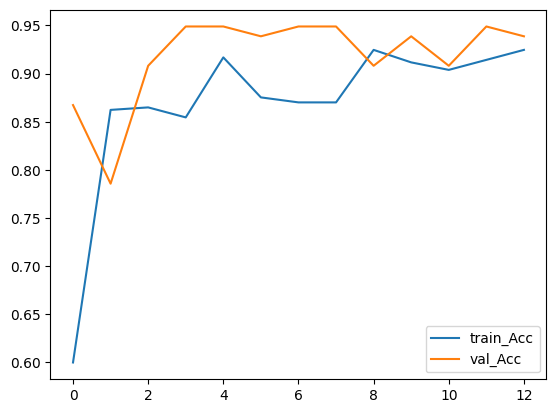

In [27]:
plt.plot(train_acc_hist, label = "train_Acc")
plt.plot(val_acc_hist, label = "val_Acc")
plt.legend()
plt.show()

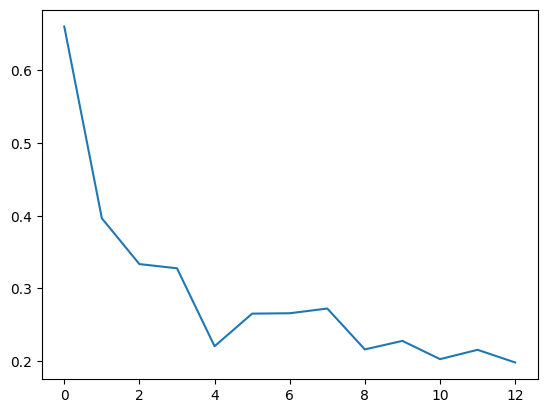

In [28]:
plt.plot(train_loss_hist)
plt.show()

# 예측 이미지 출력

In [34]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # 기존 텐서의 내용을 복사한 텐서를 생성
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1) # 값을 특정 범위로 제한
    return image

- 텐서 복사 명령어 비교
    - tensor.clone()
        - 메모리 : 새롭게 할당
        - 계산 그래프에 계속 상주(기울기에 영향을 줌)
    - tensor.detach()
        - 메모리 : 공유해서 사용
        - 계산 그래프에 상주하지 않음(기울기에 영향을 안 줌)
    - tensor.clone().detach()
        - 메모리 : 새롭게 할당
        - 계산 그래프에 상주하지 않음

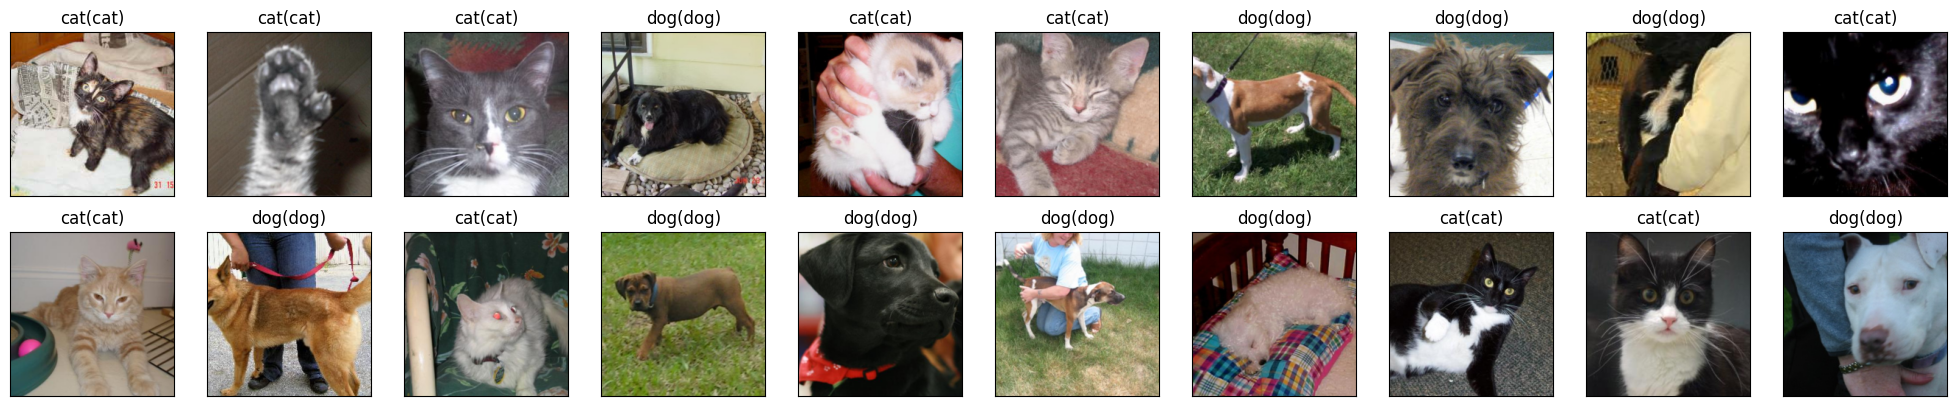

In [37]:
classes = {0 : "cat", 1 : "dog"}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = resnet18(images.to(device))
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25, 10))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
#    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx ].item()]), str(classes[labels[idx].item()]),
                                     color = "green" if preds[idx] == labels[idx] else "red"))
    
plt.show(
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0))

# 미세 조정 기법

<img src = "./image/fine_tuning.png">

- 사전 학습 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식
- 특성 추출은 목표 특성을 잘 추출했다는 전제하에 좋은 성능을 냄
    - 특성 추출이 잘못되었거나 사용할 이미지와 이미지 특징이 다르다면 미세 조정 기법으로 새로운 이미지 데이터를 이용하여 네트워크 가중치를 업데이트해서 특성을 다시 추출할 수 있음
    
- 사전 훈련된 모델을 미세 조정하여 분석하려는 데이터셋에 잘 맞도록 파라미터를 조정하는 기법

- 미세 조정 전략
    - 데이터셋이 크고 사전 훈련된 모델과 유사성이 작을 경우
        - 모델 전체를 재학습
        - 데이터셋 크기가 크기 때문에 
        
    - 데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우
        - 합성곱층의 뒷부분(완전연결층과 가까운 부분)과 데이터 분류기를 학습
        - 데이터셋이 유사하기 때문에 강한 특징이 나타나는 합성곱층의 뒷부분과 데이터 분류기만 학습해도 최적의 성능을 낼 수 있음
        
    - 데이터셋이 작고 사전 훈련된 모델과 유사성이 작을 경우
        - 합성곱층의 일부분과 데이터분류기를 학습
        - 데이터가 적기 때문에 일부 계층에 미세 조정 기법을 적용한다고 해도 효과가 없을 수 있음
        
    - 데이터셋이 작고 사전 훈련된 모델과 유사성이 클 경우
        - 데이터 분류기만 학습
        - 데이터가 적기 때문에 많은 계층에 미세 조정 기법을 적용하면 과적합이 발생할 수 있음